In [1]:
import sys
sys.path.insert(0, "../benchmark_linalg/")
import benchmark

In [2]:
import tenpy
import numpy as np

import matplotlib.pyplot as plt
from pathlib import Path
from pprint import pprint
import re

from tenpy.simulations.post_processing import DataLoader, DataFiles

In [3]:
import matplotlib as mpl
fontsize = 10
textwidth = 5.90666 # [inch], in the final paper
mpl.rc('font', size=10)
mpl.rc('legend', fontsize=8)

In [4]:
#colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
linestyles = ['-', '--', ':', '-.']


color_map_ = {}

def color_(nthreads):
    return color_map_.setdefault(nthreads, colors[len(color_map_)])
    


## DMRG

In [5]:
data_files_DMRG = DataFiles()
data_files_DMRG.load_from_folder("../run/conda/nthreads_1/")
data_files_DMRG.load_from_folder("../run/conda/nthreads_4/")


loading ../run/conda/nthreads_1/bench_cons_None_sort_False.h5 ... successful
loading ../run/conda/nthreads_1/bench_cons_None_sort_True.h5 ... successful
loading ../run/conda/nthreads_1/bench_cons_Sz_sort_False.h5 ... successful
loading ../run/conda/nthreads_1/bench_cons_Sz_sort_True.h5 ... successful
loading ../run/conda/nthreads_4/bench_cons_None_sort_False.h5 ... successful
loading ../run/conda/nthreads_4/bench_cons_Sz_sort_False.h5 ... successful


In [6]:
def extract_time_per_sweep(data:DataLoader):
    """Extract arrays (chi, time_per_sweeps) from DataLoader"""
    chi_list = data.sim_params['algorithm_params']['chi_list']
    expected_chis = sorted(chi_list.values())[1:]
    actual_chi = np.max(data.measurements['bond_dimension'], axis=1)
    walltimes = data.measurements['walltime']
    delta_walltime = walltimes[1:] - walltimes[:-1]
    # exclude sweeps where we increased bond dimension
    keep = (actual_chi[1:] == actual_chi[:-1]) 
    actual_chi = actual_chi[1:][keep]
    delta_walltime = delta_walltime[keep]
    assert len(actual_chi) == len(delta_walltime)
    mean_per_sweep = []
    for chi in expected_chis:
        per_sweep = delta_walltime[actual_chi == chi]
        if len(per_sweep) > 0:
            mean_per_sweep.append(np.mean(per_sweep))
        else:
            mean_per_sweep.append(np.nan)
    return np.array(expected_chis), np.array(mean_per_sweep)

In [7]:
def read_itensor_output(filename, expected_header="# sweep maxlinkdim walltime"):
    """Given a filename of a timing_*.txt file in ../itensor/, return `chis, timings`."""
    with open(filename, 'r') as f:
        lines = f.readlines()
    header = lines.pop(0)[:-1] # without newline
    if header != expected_header:
        raise ValueError(f"unexpected header reading {filename}:\n"
                         f"expected {expected_header!r}, got {header}")
    last_n = 0
    last_chi = 0
    chis = []
    times = []
    current_times_avg = []
    last_walltime = 0.
    for line in lines:
        n, chi, walltime = line.split()
        n = int(n)
        chi = int(chi)
        walltime = float(walltime)
        assert n == last_n + 1  # TODO: multiple results in one file?
        last_n = n
        if chi == last_chi:
            current_times_avg.append(walltime - last_walltime)
        else:
            if len(current_times_avg) > 0:
                chis.append(last_chi)
                times.append(np.mean(current_times_avg))
            last_chi = chi
            current_times_avg = [] # don't include timings of sweeps where chi changed
        last_walltime = walltime
    if len(current_times_avg) > 0:
        chis.append(last_chi)
        times.append(np.mean(current_times_avg))
    return np.array(chis), np.array(times)

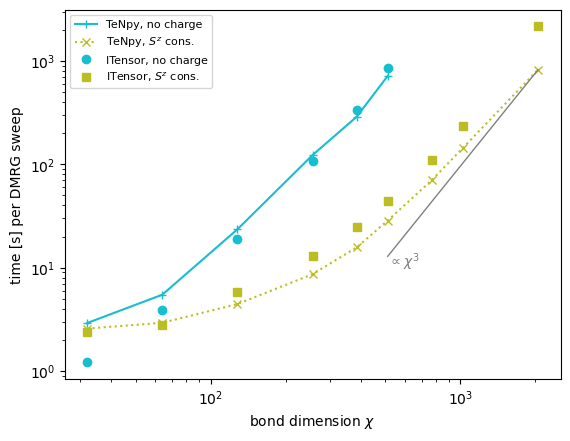

In [8]:
def plot_tenpy_itensor_vs_chi(ax, *, legend=True, 
        labels=["TeNpy, no charge",
                "TeNpy, $S^z$ cons.",
                # "TeNpy, no charge, 4 cores",
                # "TeNpy, cons. Sz., 4 cores",
                "ITensor, no charge",
                "ITensor, $S^z$ cons."],
        legend_kwargs={}                   
    ):
    col_None = colors[-1]
    col_Sz = colors[-2]


    file = "../run/conda/nthreads_1/bench_cons_None_sort_False.h5"
    chis, time_per_sweep = extract_time_per_sweep(data_files_DMRG[file])
    ax.plot(chis, time_per_sweep, color=col_None, linestyle="-", marker='+', label=labels[0])
    file = "../run/conda/nthreads_1/bench_cons_Sz_sort_False.h5"
    chis, time_per_sweep = extract_time_per_sweep(data_files_DMRG[file])
    ax.plot(chis, time_per_sweep, color=col_Sz, linestyle=":", marker='x', label=labels[1])
    
    # file = "../run/conda/nthreads_4/bench_cons_None_sort_False.h5"
    # chis, time_per_sweep = extract_time_per_sweep(data_files_DMRG[file])
    # ax.plot(chis, time_per_sweep, color=color_(4), linestyle="-", marker='+', label=labels[2])
    # file = "../run/conda/nthreads_4/bench_cons_Sz_sort_False.h5"
    # chis, time_per_sweep = extract_time_per_sweep(data_files_DMRG[file])
    # ax.plot(chis, time_per_sweep, color=color_(4), linestyle=":", marker='+', label=labels[3])
    
    i_chis, i_time_per_sweep = read_itensor_output("../itensor/timings_nthreads_01_conserve_False.out")
    ax.plot(i_chis, i_time_per_sweep, color=col_None, marker='o', linestyle='', label=labels[2])
    i_chis, i_time_per_sweep = read_itensor_output("../itensor/timings_nthreads_01_conserve_True.out")
    ax.plot(i_chis, i_time_per_sweep, color=col_Sz, marker='s', linestyle='', label=labels[3])
    
    chi_fit = np.array([512, 2048])
    chi_fit_pow3 = chi_fit**3 * (time_per_sweep[-1]/chis[-1]**3)
    ax.plot(chi_fit, chi_fit_pow3, linestyle='-', color='gray', linewidth=1.)#, label=r"$\propto \chi^3$")
    ax.text(chi_fit[0], chi_fit_pow3[0] * 0.8, r"$\propto \chi^3$", color='gray')
    if legend:
        if labels == [None]*6:
            patches = []
            labels = []
            import matplotlib.lines as mlines
            patches.append(mlines.Line2D([], [], linestyle='-', marker='+', color='k'))
            labels.append("TeNPy")
            patches.append(mlines.Line2D([], [], linestyle='', marker='o', color='k'))
            labels.append("ITensor")
            ax.legend(patches, labels, loc='upper left', **legend_kwargs)
        else:
            ax.legend(loc='upper left', **legend_kwargs)
    ax.set_ylabel('time [s] per DMRG sweep')
    ax.set_xlabel(r'bond dimension $\chi$')
    ax.set_xscale('log')
    ax.set_yscale('log')
    

fig = plt.figure()
plot_tenpy_itensor_vs_chi(plt.gca())
plt.show() 

## Linalg

In [9]:
data_linalg = []
for folder in Path('../run_linalg/').glob('nthreads_*'):
    nthreads = int(folder.name[len('nthreads_'):])
    
    for fn in folder.glob('*.txt'):
        sizes, results, kwargs = benchmark.load_results(fn)
        kwargs['nthreads'] = nthreads
        data_linalg.append((sizes, results, kwargs))

In [10]:
kwargs

{'mod_q': [1],
 'legs': 2,
 'sectors': 10,
 'max_time': 0.1,
 'repeat_bestof': 3,
 'python_version': '3.12.4 | packaged by conda-forge | (main, Jun 17 2024, 10:23:07) [GCC 12.3.0]',
 'mod_name': 'tensordot_numpy',
 'nthreads': 1}

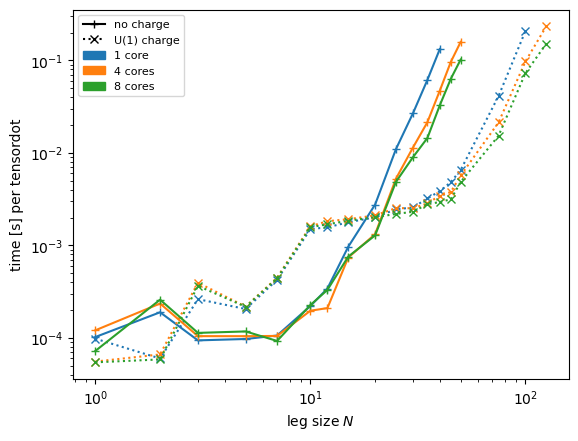

In [11]:
def plot_linalg_tensordot(ax, nthreads_plot = [1, 4, 8], legend_kwargs={}):

    # linestyle_map = {tuple([]): "-", tuple([1]): "--"}
    # for sizes, results, kwargs in data_linalg:
    #     if kwargs['mod_name'] != 'tensordot_npc' or kwargs['legs'] != 2:
    #         continue
    #     charge = kwargs['mod_q']
    #     ls = "--" if charge == [1] else "-"
    for nthreads in nthreads_plot:
        fn = f"../run_linalg/nthreads_{nthreads:d}/tensordot_npc_benchmark_s_10_l_2_mod_q_.txt"
        sizes, results, kwargs = benchmark.load_results(fn)
        ax.plot(sizes, results, color=color_(nthreads), linestyle='-', marker='+')
        fn = f"../run_linalg/nthreads_{nthreads:d}/tensordot_npc_benchmark_s_10_l_2_mod_q_1.txt"
        sizes, results, kwargs = benchmark.load_results(fn)
        ax.plot(sizes, results, color=color_(nthreads), linestyle=':', marker='x')
        
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r"leg size $N$")
    ax.set_ylabel(r"time [s] per tensordot")

    # add legend
    patches = []
    labels = []
    import matplotlib.patches as mpatches
    import matplotlib.lines as mlines
    patches.append(mlines.Line2D([], [], linestyle='-', marker='+', color='k'))
    labels.append("no charge")
    patches.append(mlines.Line2D([], [], linestyle=':', marker='x', color='k'))
    labels.append("U(1) charge")
    for nthreads in nthreads_plot:
        patches.append(mpatches.Patch(color=color_(nthreads)))
        labels.append(f"{nthreads} core" + ('s' if nthreads > 1 else ''))


    ax.legend(patches, labels, **legend_kwargs)



fig = plt.figure()
plot_linalg_tensordot(plt.gca())
plt.show()

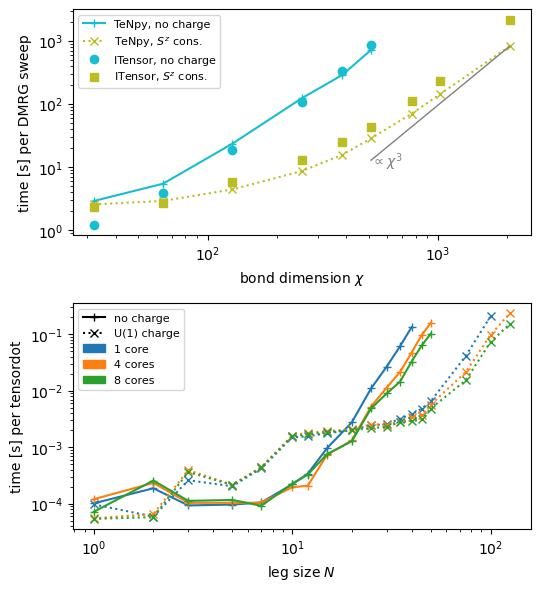

In [12]:
figwidth=textwidth
fig, axes = plt.subplots(2, 1, figsize=(figwidth, figwidth))
plt.subplots_adjust(top=0.98, bottom=0.1, hspace=0.3)
plot_tenpy_itensor_vs_chi(axes[0])
plot_linalg_tensordot(axes[1])

plt.savefig("benchmark.pdf")